[INFO] loading images...


C:\Users\99655\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9420800/9406464 [==============================] - 22s 2us/step
[INFO] compiling model...
[INFO] training head...


C:\Users\99655\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
95/95 [==============================] - 100s 1s/step - loss: 0.4127 - accuracy: 0.8586 - val_loss: 0.1717 - val_accuracy: 0.9817
Epoch 2/20
95/95 [==============================] - 99s 1s/step - loss: 0.1607 - accuracy: 0.9657 - val_loss: 0.0841 - val_accuracy: 0.9883
Epoch 3/20
95/95 [==============================] - 99s 1s/step - loss: 0.1139 - accuracy: 0.9697 - val_loss: 0.0602 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 96s 1s/step - loss: 0.0828 - accuracy: 0.9812 - val_loss: 0.0489 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 98s 1s/step - loss: 0.0707 - accuracy: 0.9799 - val_loss: 0.0435 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 97s 1s/step - loss: 0.0619 - accuracy: 0.9829 - val_loss: 0.0398 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 92s 963ms/step - loss: 0.0555 - accuracy: 0.9845 - val_loss: 0.0360 - val_accuracy: 0.9922
Epoch 8/20
95/95

C:\Users\99655\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


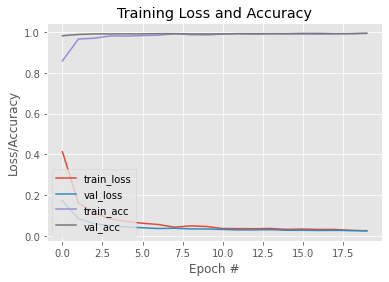

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# обьвлять(указывать) the скорость обучения(learning rate), количество эпох для тренирвки алгоритма,
# размер batch
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"dataset"
CATEGORIES = ["with_mask", "without_mask"]

#список фотографий
#список данных (т.е. изображений) и изображений классов
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

# encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)


aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

# компиляция модели
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])


print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# прогнозы на тестовом наборе 
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

#для каждого изображения в тестовом наборе находим индекс, label с соответствующей наибольшая прогнозируемой вероятностью
predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# сохранить модель
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# график trainig loss и   accuracy 

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")